In [1]:
import numpy as np
import torch
from torch.optim import Adam
import scipy

# Function to train a linear state-space model using Adam optimizer with BPTT
def train_lssm_bptt(X, U, Y, seq_len=499, learning_rate=0.1, epochs=800):
    """
    Trains a Linear State Space Model (LSSM) of the form:
        x_{t+1} = A x_t + B u_t
        y_t = C x_t + D u_t

    Using Back-Propagation Through Time (BPTT).

    Parameters:
    -----------
    X : ndarray, shape (T, n)
        State trajectory data (T time steps, n state dimensions).
    U : ndarray, shape (T, m)
        Input trajectory data (T time steps, m input dimensions).
    Y : ndarray, shape (T, p)
        Output trajectory data (T time steps, p output dimensions).
    seq_len : int, optional (default=10)
        Sequence length for BPTT.
    learning_rate : float, optional (default=0.01)
        Learning rate for the Adam optimizer.
    epochs : int, optional (default=500)
        Number of training iterations.

    Returns:
    --------
    A : ndarray, shape (n, n)
        State transition matrix.
    B : ndarray, shape (n, m)
        Control input matrix.
    C : ndarray, shape (p, n)
        Output state matrix.
    D : ndarray, shape (p, m)
        Output control matrix.
    """
    # Ensure trajectories have the same length
    assert X.shape[0] == U.shape[0] == Y.shape[0], "Input, and output trajectories must have the same number of time steps."

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    U_tensor = torch.tensor(U, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.float32)

    # Initialize A, B, C, and D randomly
    n = X.shape[1]  # Number of states
    m = U.shape[1]  # Number of inputs
    p = Y.shape[1]  # Number of outputs
    A = 0.1 * torch.randn(n, n, dtype=torch.float32) 
    B = torch.randn(n, m, requires_grad=True, dtype=torch.float32)
    C = torch.randn(p, n, requires_grad=True, dtype=torch.float32)
    D = torch.randn(p, m, requires_grad=True, dtype=torch.float32)
    A.requires_grad = True
    
    # Define optimizer
    optimizer = Adam([A, B, C, D], lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0

        # Iterate through sequences
        for t in range(0, U.shape[0] - seq_len):
            # Extract sequences for BPTT
            x_seq = X_tensor[t : t + seq_len]  # T * d_hidden
            u_seq = U_tensor[t : t + seq_len]  # T * d_in
            y_seq = Y_tensor[t : t + seq_len]  # T * d_out

            # Initialize hidden state for the sequence
            x_pred = x_seq[0]  # Initial state for prediction (1, d_hidden)

            # Initialize losses
            loss = 0.0

            # Forward pass through the sequence
            for k in range(seq_len - 1):
                # Predict next state and output
                y_pred = x_pred @ C.T + u_seq[k] @ D.T
                x_pred = x_pred @ A.T + u_seq[k] @ B.T

                # Compute losses
                loss += torch.mean((y_pred - y_seq[k]) ** 2)

            # Total loss for the sequence
            total_loss += loss

        # Average loss across sequences
        total_loss /= (U.shape[0] - seq_len)

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print loss every 50 epochs
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss.item():.6f}")

    # Detach A, B, C, and D from computation graph and convert to numpy
    A_final = A.detach().numpy()
    B_final = B.detach().numpy()
    C_final = C.detach().numpy()
    D_final = D.detach().numpy()

    return A_final, B_final, C_final, D_final



In [10]:
# Generate synthetic trajectory data
np.random.seed(42)
T, n, m, p = 500, 10, 10, 10  # Time steps, state dimension, input dimension, output dimension
    
# True system matrices
#A_true = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['A']) 
#B_true = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['B'])
#C_true = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['C'])
#D_true =  np.zeros((p, m))
data_path = '../../data/adam_sys_id/' 
#U = np.asarray(scipy.io.loadmat(data_path + '/train_data.mat')['u']).reshape(T,m)
#Y = np.asarray(scipy.io.loadmat(data_path + '/train_data.mat')['y']).reshape(T,p)


# Uncomment the following to generate data from the discrete-time system
# State Space Model (LTI System)
A_true = 0.1 * np.triu((np.random.rand(n, n)))  # State matrix
for i in range(n):  # Set eigenvalues of the state matrix
    A_true[i, i] = -4.0 + 2.5 ** (-((i)))
B_true = 0.5 * np.random.rand(n, m)  # Input Matrix
C_true = 0.5 * np.random.rand(p, n)  # Output matrix
D_true = np.zeros((p, m))  #-0.5 * np.random.rand(p, m)  # Feedforward matrix
print(np.linalg.eig(A_true))

dt = 0.01
timesteps = np.arange(0,1,0.01)
A_true = dt * A_true + np.identity(n)
B_true = B_true * dt

# Generate random inputs and initial state

U = np.random.randn(T, m)
X = np.zeros((T, n))
Y = np.zeros((T, p))

# Simulate trajectory
for t in range(1, T):
    X[t] = A_true @ X[t-1] + B_true @ U[t-1]
    Y[t] = C_true @ X[t] + D_true @ U[t] 





(array([-3.        , -3.6       , -3.84      , -3.936     , -3.9744    ,
       -3.98976   , -3.995904  , -3.9983616 , -3.99934464, -3.99973786]), array([[ 1.00000000e+00, -1.56499929e-01, -4.51950793e-02,
        -3.48114046e-02,  4.05835264e-02, -3.48439738e-02,
         2.92045310e-02, -2.52116559e-02,  2.30392285e-02,
        -2.20698835e-02],
       [ 0.00000000e+00,  9.87677970e-01, -3.27363917e-01,
         2.92613692e-02,  6.26007966e-03, -3.68277767e-03,
        -1.53707906e-02,  3.06484762e-02, -3.76204849e-02,
         4.03828477e-02],
       [ 0.00000000e+00,  0.00000000e+00,  9.43816863e-01,
        -3.56176735e-01,  1.26764283e-01, -9.59345248e-02,
         1.06298551e-01, -1.14861501e-01,  1.17164480e-01,
        -1.17627110e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.33311348e-01, -9.20936050e-01,  8.11449618e-01,
        -6.94126203e-01,  5.82043421e-01, -5.15470079e-01,
         4.85064720e-01],
       [ 0.00000000e+00,  0.00000000e+00,

In [3]:
# Train LSSM using Adam optimizer with BPTT
A_est, B_est, C_est, D_est = train_lssm_bptt(X, U, Y)


Epoch 25/800, Total Loss: 502.324554
Epoch 50/800, Total Loss: 46.461887
Epoch 75/800, Total Loss: 7.560202
Epoch 100/800, Total Loss: 4.181213
Epoch 125/800, Total Loss: 3.808885
Epoch 150/800, Total Loss: 3.728545
Epoch 175/800, Total Loss: 3.686642
Epoch 200/800, Total Loss: 3.656062
Epoch 225/800, Total Loss: 3.629417
Epoch 250/800, Total Loss: 3.603725
Epoch 275/800, Total Loss: 3.577480
Epoch 300/800, Total Loss: 3.549730
Epoch 325/800, Total Loss: 3.519670
Epoch 350/800, Total Loss: 3.486424
Epoch 375/800, Total Loss: 3.448911
Epoch 400/800, Total Loss: 3.405735
Epoch 425/800, Total Loss: 3.355016
Epoch 450/800, Total Loss: 3.294156
Epoch 475/800, Total Loss: 3.219390
Epoch 500/800, Total Loss: 3.124894
Epoch 525/800, Total Loss: 3.000782
Epoch 550/800, Total Loss: 2.827697
Epoch 575/800, Total Loss: 2.558553
Epoch 600/800, Total Loss: 2.029435
Epoch 625/800, Total Loss: 0.452125
Epoch 650/800, Total Loss: 0.032137
Epoch 675/800, Total Loss: 0.016005
Epoch 700/800, Total Loss: 0

0.005425483018781293


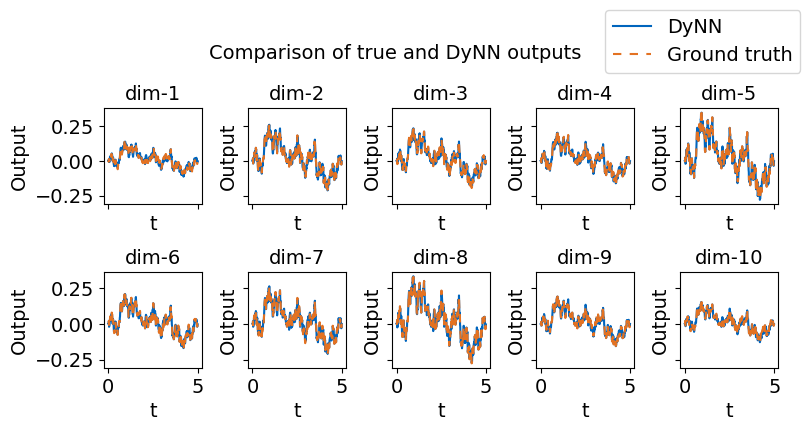

In [4]:
# Compute estimated states and outputs from data
X_est = np.zeros((T, n))
Y_est = np.zeros((T, p))
X_est[0] = X[0]

A_est = A_est
for t in range(1, T):
    X_est[t] = A_est @ X_est[t-1] + B_est @ U[t-1] 
    Y_est[t] = C_est @ X_est[t] + D_est @ U[t] 

#  Comparaison of discrete time-systems
print(np.sqrt(np.mean((Y_est - Y)**2)))

# Plot 
import matplotlib.pyplot as plt
fontsize=14
timesteps = np.arange(0,5,0.01)
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex='col', sharey='row')
# Loop through the axes and plot data
for i, ax in enumerate(axes.flat):
    ax.plot(timesteps, Y_est[:, i], label='DyNN', color="#0065bd")
    ax.plot(timesteps, Y[:, i],  label='Ground truth', 
            color="#e37222", linestyle='--', dashes=(4,4))
    ax.set_title(f"dim-{i+1}", fontsize = fontsize) 
    ax.set_ylabel(f"Output", fontsize = fontsize)
    ax.set_xlabel('t', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1, 
        bbox_to_anchor=(0.75, 1.09), fontsize=fontsize)

plt.suptitle("Comparison of true and DyNN outputs", fontsize=fontsize)
fig.tight_layout()
plt.savefig('sys_id.pdf')
plt.show()

0.022936586919174873


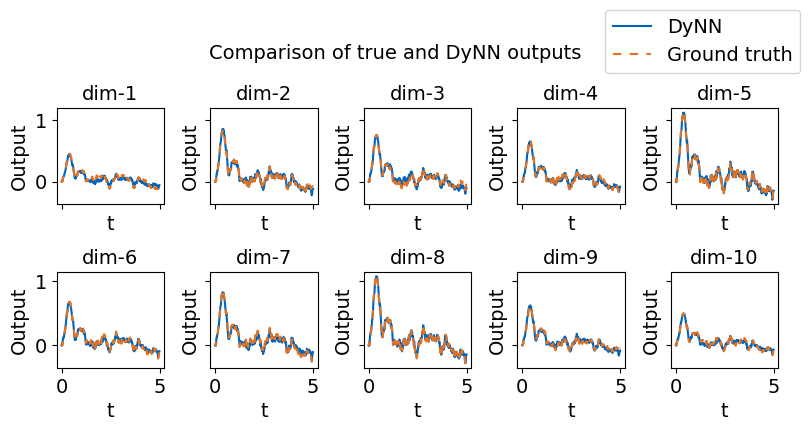

In [5]:
# Compute estimated states and outputs from data
X_est_test = np.zeros((T, n))
Y_est_test = np.zeros((T, p))

U_test = np.random.randn(T, m) #np.ones((T,m)) #np.random.randn(T, m)
for i in range(m):
    U_test[:, i] += np.sin((i+1) * timesteps)

X_test = np.zeros((T, n))
Y_test = np.zeros((T, p))
for t in range(1, T):
    X_test[t] = A_true @ X_test[t-1] + B_true @ U_test[t-1]
    Y_test[t] = C_true @ X_test[t] + D_true @ U_test[t] 

    X_est_test[t] = A_est @ X_est_test[t-1] + B_est @ U_test[t-1] 
    Y_est_test[t] = C_est @ X_est_test[t] + D_est @ U_test[t] 

# Comparaison of discrete time-systems
print(np.sqrt(np.mean((Y_est_test - Y_test)**2)))

# Plot 
import matplotlib.pyplot as plt
fontsize=14
timesteps = np.arange(0,5,0.01)
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex='col', sharey='row')
# Loop through the axes and plot data
for i, ax in enumerate(axes.flat):
    ax.plot(timesteps, Y_est_test[:, i], label='DyNN', color="#0065bd")
    ax.plot(timesteps, Y_test[:, i],  label='Ground truth', 
            color="#e37222", linestyle='--', dashes=(4,4))
    ax.set_title(f"dim-{i+1}", fontsize = fontsize) 
    ax.set_ylabel(f"Output", fontsize = fontsize)
    ax.set_xlabel('t', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1, 
        bbox_to_anchor=(0.75, 1.09), fontsize=fontsize)

plt.suptitle("Comparison of true and DyNN outputs", fontsize=fontsize)
fig.tight_layout()
plt.savefig('sys_id_dynn.png')
plt.show()

In [11]:
from scipy.io import savemat

# Convert true matrices to continuous time
A_c_true = (A_true - np.identity(n))/dt
B_c_true = B_true/dt
C_c_true = C_true
D_c_true = D_true
evals_c, evec_c = np.linalg.eig(A_c_true)
print(evals_c)

# Convert learned matrices to continuous-time
A_c_est = (A_est - np.identity(n))/dt
B_c_est = B_est/dt
C_c_est = C_est
D_c_est = D_est
evals_c_est, evec_c_est = np.linalg.eig(A_c_est)
print(evals_c_est)

# Save the continuous-time matrices
np.savez(data_path + 'ssm_adam_500.npz', A=A_c_est, B=B_c_est, C=C_c_est, D=D_c_est)
np.savez(data_path + 'data_500.npz', U=U, Y=Y)
np.savez(data_path + 'data_500_test.npz', U_test=U_test, Y_test=Y_test)


# Save matrices to a .mat file
data = {'U': U, 'Y': Y}
savemat(data_path + 'data_500.mat', data)

# Save matrices to a .mat file
data_test = {'U_test': U_test, 'Y_test': Y_test}
savemat(data_path + 'data_500_test.mat', data_test)

[-3.         -3.6        -3.84       -3.936      -3.9744     -3.98976
 -3.995904   -3.9983616  -3.99934464 -3.99973786]
[  -3.57074685+0.j         -116.86312336+9.00617241j
 -116.86312336-9.00617241j -101.22326381+3.39441909j
 -101.22326381-3.39441909j  -79.15008837+0.j
  -94.24761576+0.j          -83.72128347+0.j
  -86.68943494+0.j          -87.80999756+0.j        ]
